See OneNote for my Notes (explains most things)

-Performing a Wilcoxon Signed Rank Test
    --> Two groups (beamformed vs mono), Dependent (detections on the same sample species), Non-normal - see following plots (for mono data).

The clearest plots to interprete are those for:
    TS (Tawny-bellied Screech-Owl) - 752 overall detections
    MP (Mealy Parrot) - 107 overall detections
    GT (Green-backed Trogon) - 47 detections

All of these seem non-normal, very skewed (either to the right - MP & TS) or to the left (GT)


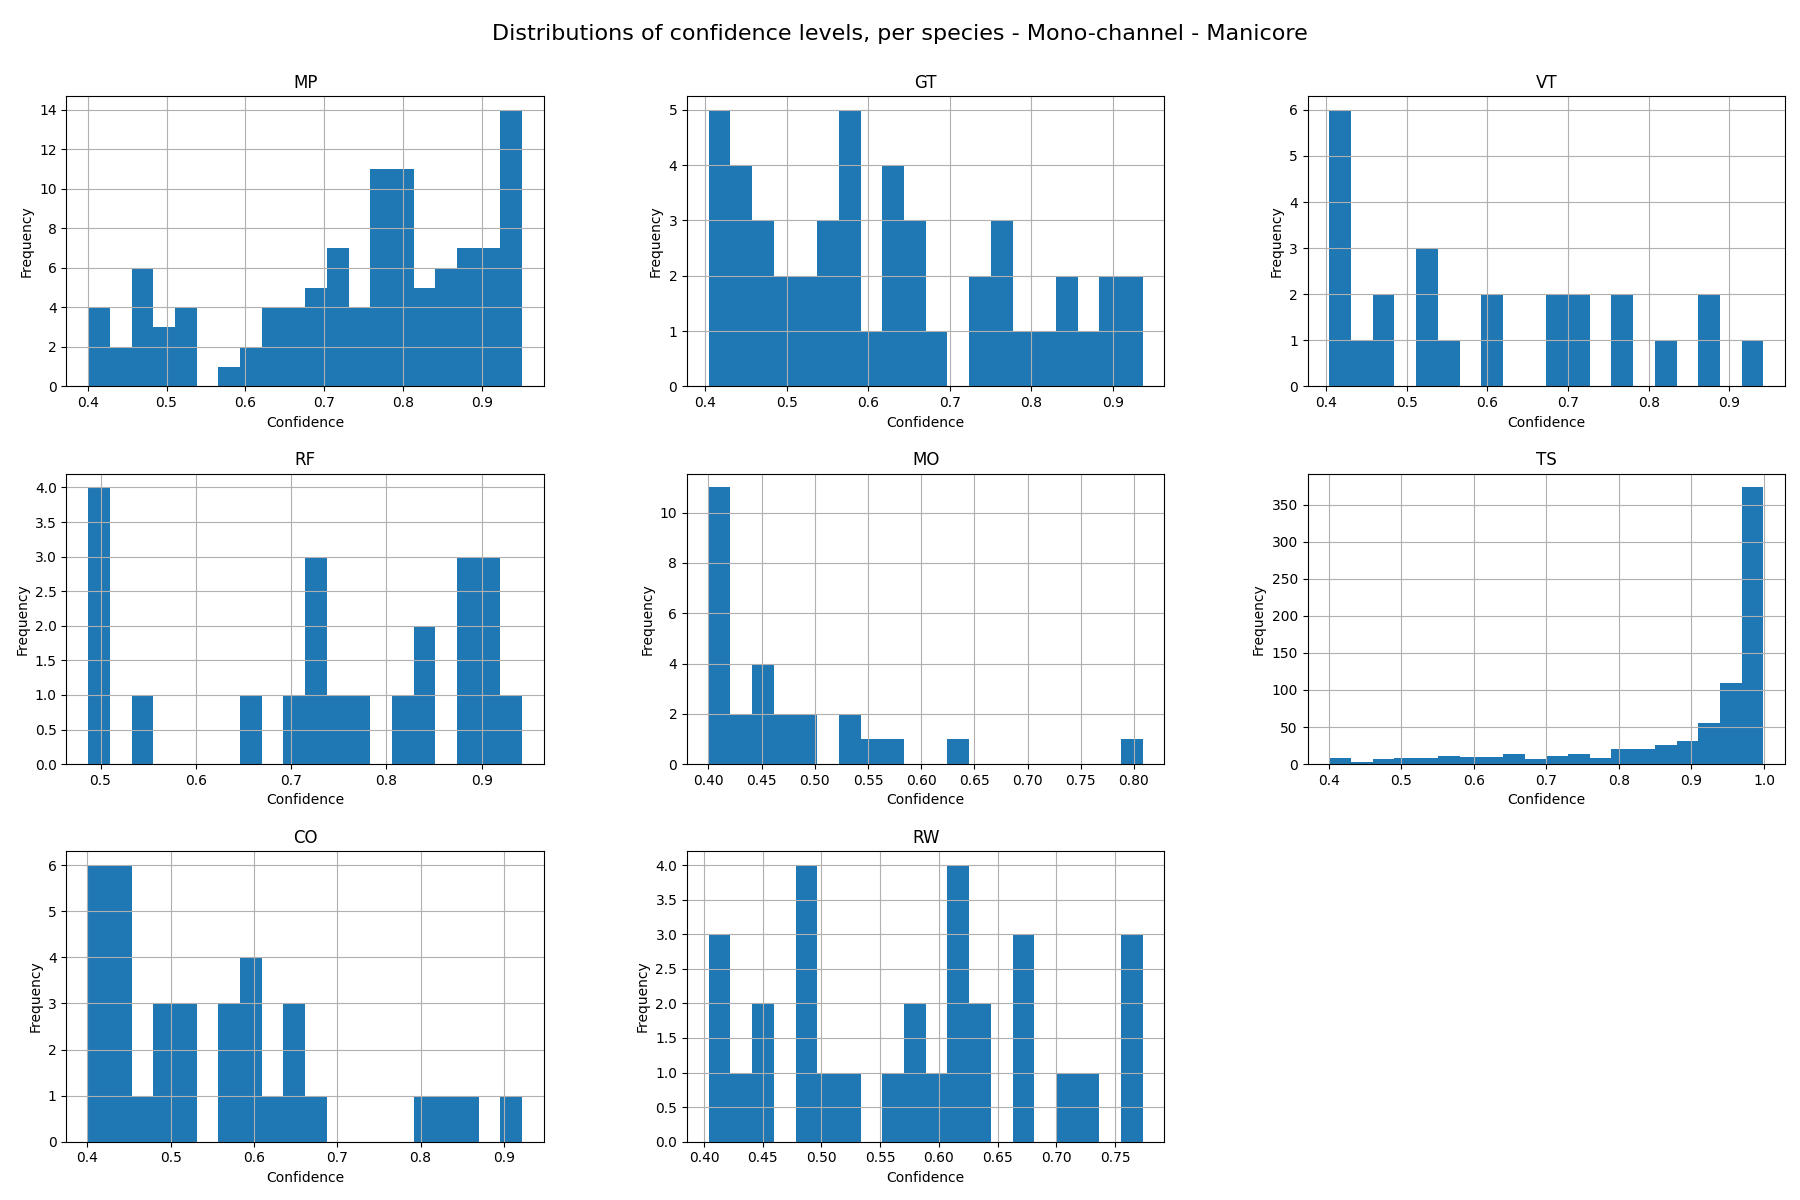

In [21]:
%matplotlib inline
from IPython.display import Image
Image('data/processed/manicore/mono_hists.png')
# Image('data/processed/silwood/A1/mono_hists.png')

We need to conduct statistical power analysis - to determine our minimum sample size required. For the Wilcoxon signed rank test, we must run a simulation-based power analysis. This requires an underlying model of our distribution...

Let's try find the best model for the TS distribution...

--> This should hopefully represent birdNET detections well as a whole (as we have almost 800 detections)
    --> If we calculate a min sample size for this (to give a good statistical power), we can then re-run our statistical inference tesMP over all species above the min sample size (above the threshold number of detections)

I've followed this article for fitting - https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9

In [2]:
import json
from pprint import pprint

In [3]:
def read_results_from_file(file_path):
    """Read the BirdNET detections from a file"""

    with open(file_path, 'r') as file:
        results_dict = json.load(file)

    return results_dict

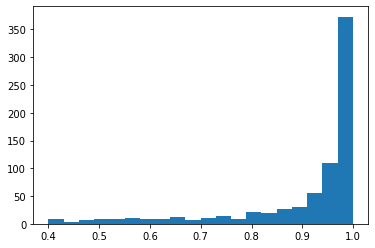

['cauchy', 'chi2', 'expon', 'exponpow', 'gamma', 'lognorm', 'norm', 'powerlaw', 'rayleigh', 'uniform']


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions


mono_dict = read_results_from_file("data/processed/manicore/processed.json")["mono_channel"]

TS_conf = mono_dict["Tawny-bellied Screech-Owl"]["conf_list"]

plt.hist(TS_conf, bins=20)
plt.show()
# pprint(TS_conf)

print(get_common_distributions())

Fitting 6 distributions: 100%|██████████| 6/6 [00:31<00:00,  5.27s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,521.334335,342.295014,-249.000322,inf,0.179282,1.281863e-21
norm,1679.450364,166.742495,617.466592,inf,0.249513,9.834746e-42
gamma,1702.128576,156.282245,634.175901,inf,0.258070,1.170925e-44
rayleigh,1880.809319,-6.830072,702.619761,inf,0.331840,2.664395e-74
expon,2034.388578,-14.246421,761.646608,inf,0.390721,6.403920e-104


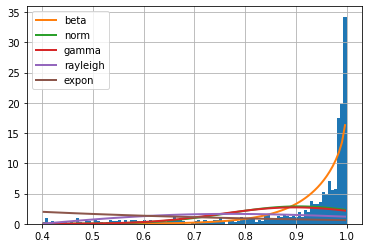

In [29]:
# Create a fitter object - pass in likely common distributions (from eyeballing)
f = Fitter(TS_conf,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "expon",
                          "rayleigh",
                          "norm"])

# Alternatively, try all types of distribution (will take much longer to run)
# f = Fitter(TS_conf)

f.fit()
f.summary()

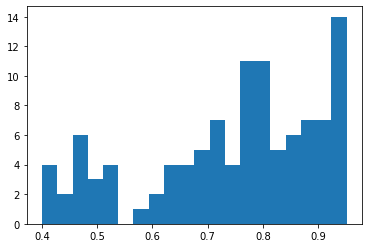

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,275.217323,-76.919009,119.777662,inf,0.095281,2.683454e-01
lognorm,355.415484,-59.349122,142.467562,inf,0.117767,9.473071e-02
gamma,361.863957,-60.685295,144.391513,inf,0.128164,5.429191e-02
rayleigh,397.591874,-74.871730,149.793558,inf,0.177201,2.072125e-03
expon,493.789571,-49.409296,172.978684,inf,0.283077,4.438658e-08


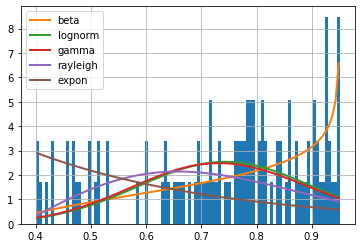

In [30]:
# Same, but for the Mealy Parrot...

MP_conf = mono_dict["Mealy Parrot"]["conf_list"]

plt.hist(MP_conf, bins=20)
plt.show()

f2 = Fitter(MP_conf,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "expon",
                          "rayleigh"])

# Alternatively, try all types of distribution (will take much longer to run)
# f = Fitter(TS_conf)

f2.fit()
f2.summary()



In [32]:
pprint(f.get_best(method="sumsquare_error"))
pprint(f2.get_best(method="sumsquare_error"))

{'beta': {'a': 37.090656975650134,
          'b': 0.8942071078828668,
          'loc': -1.8776027850831252,
          'scale': 2.876616089793514}}
{'beta': {'a': 1.5718154845395125,
          'b': 0.7655057781029281,
          'loc': 0.3557972880305498,
          'scale': 0.5955634144840988}}


It seems like the best-fit model is the Beta distribution. Let's use this to conduct our simulated statistical power analysis...

In [4]:
from scipy.stats import wilcoxon, beta

# Set the parameters for the power analysis
effect_size = 0.1
alpha = 0.05

# Define the function to calculate power
def calculate_power(n, a, b, loc, scale):
    num_simulations = 1000  # Number of simulations
    rejected = 0  # Counter for rejected null hypotheses

    shifted_a = a + (effect_size * (b/2))

    for i in range(num_simulations):
        # Generate synthetic data with the desired effect size
        sample1 = beta.rvs(a=a, b=b, loc=loc, scale=scale, size=n)
        sample2 = beta.rvs(a=shifted_a, b=b, loc=loc, scale=scale, size=n)

        # Perform the Wilcoxon signed-rank test
        i, p_value = wilcoxon(sample1, sample2, alternative='two-sided')

        # Check if the null hypothesis is rejected
        if p_value < alpha:
            rejected += 1

    # Calculate the power
    power_estimate = rejected / num_simulations
    return power_estimate

In [51]:
# For the Tawny-bellied Screech-Owl--------------------------------------

# Extract the parameters from our distributions (fitted previously)
fit_params_TS = f.get_best(method="sumsquare_error")
a_TS = fit_params_TS["beta"]["a"]
b_TS = fit_params_TS["beta"]["b"]
loc_TS = fit_params_TS["beta"]["loc"]
scale_TS = fit_params_TS["beta"]["scale"]
print(f"{a_TS}, {b_TS}, {loc_TS}, {scale_TS}")

# Perform the power analysis for different sample sizes
sample_sizes = [10, 50, 100, 200, 400]
for n in sample_sizes:
    power_estimate = calculate_power(n, a_TS, b_TS, loc_TS, scale_TS)
    print(f"Sample Size: {n}, Power: {power_estimate}")

37.090656975650134, 0.8942071078828668, -1.8776027850831252, 2.876616089793514
Sample Size: 10, Power: 0.057
Sample Size: 50, Power: 0.048
Sample Size: 100, Power: 0.043
Sample Size: 200, Power: 0.048
Sample Size: 400, Power: 0.043


In [46]:
# For the Mealy Parrot--------------------------------------

# Extract the parameters from our distributions (fitted previously)
fit_params_MP = f2.get_best(method="sumsquare_error")
a_MP = fit_params_MP["beta"]["a"]
b_MP = fit_params_MP["beta"]["b"]
loc_MP = fit_params_MP["beta"]["loc"]
scale_MP = fit_params_MP["beta"]["scale"]
print(f"{a_MP}, {b_MP}, {loc_MP}, {scale_MP}")

# Perform the power analysis for different sample sizes
sample_sizes = [10, 50, 100, 200, 400]
for n in sample_sizes:
    power_estimate = calculate_power(n, a_MP, b_MP, loc_MP, scale_MP)
    print(f"Sample Size: {n}, Power: {power_estimate}")

1.5718154845395125, 0.7655057781029281, 0.3557972880305498, 0.5955634144840988
Sample Size: 10, Power: 0.008
Sample Size: 50, Power: 0.0
Sample Size: 100, Power: 0.0
Sample Size: 200, Power: 0.0
Sample Size: 400, Power: 0.0


Let's run the Wilcoxon tests!

In [5]:
def get_species_mean_med_dev(file_path, species_name):
    """Returns the means, medians and standard deviations of a species,
    rounded to 2 d.p, for both beamformed [0] and mono [1] channels"""

    bf_dict = read_results_from_file(file_path)["beamformed"]
    mono_dict = read_results_from_file(file_path)["mono_channel"]

    means = [round(bf_dict[species_name]["conf_avg"], 2), round(mono_dict[species_name]["conf_avg"], 2)]
    medians = [round(bf_dict[species_name]["conf_median"], 2), round(mono_dict[species_name]["conf_median"], 2)]
    devs = [round(bf_dict[species_name]["conf_stdev"], 2), round(mono_dict[species_name]["conf_stdev"], 2)]

    return means, medians, devs

In [34]:
from pprint import pprint

# signifance_level = 0.05

signifance_level = 0.05/24      # Using the Bonferroni

def report_outcome(means, medians, devs, z_val, p_val):
    if p_val < 0.05:
        p_val = round(p_val, 3)

        if p_val < 0.001:
            p_str = "p<0.001"
        else:
            p_str = "p=" + str(p_val)

        print(f"The data is not normally distributed, and descriptive analysis shows \nthat"
            + f" the mean confidence level using beamforming ({str(means[0])}, StDev={str(devs[0])})"
            + f" is higher\nthan the mean confidence level using the mono-channel benchmark"
            + f" recordings \n({str(means[1])}, StDev={str(devs[1])}). It is also noted that the median"
            + f" for beamforming ({str(medians[0])})\nis higher than the median for the mono-channel"
            + f" recordings ({str(medians[1])}).\n\n"
            + f"Non parametric statistics has been used. Wilcoxon signed rank test analysis shows\n"
            + f"that this difference is significant (Z={str(z_val)}, {p_str}).")
    else:
        print("Not significant!")

In [82]:
# Tawny-bellied Screech-Owl, from Manicore data...

manicore_file_path = "data/processed/manicore/processed.json"
species = "Tawny-bellied Screech-Owl"

mono_dict = read_results_from_file(manicore_file_path)["mono_channel"]
bf_dict = read_results_from_file(manicore_file_path)["beamformed"]

means, medians, devs = get_species_mean_med_dev(manicore_file_path, species)

TS_conf_mono = mono_dict[species]["conf_list"]
TS_conf_bf = bf_dict[species]["conf_list"]

# Note - put beamformed first (as the "x" values), as it will calculate x-y for the differences
statistic, p_value = wilcoxon(TS_conf_bf, TS_conf_mono, alternative="two-sided")

# Print the test statistic and p-value
print("Two-sided test (is there a signifcant difference)---------------------------")
print("Test Statistic:", statistic)
print("P-value:", p_value)

# Now, repeat with one-sided (to prove conf levels are better after beamforming)
statistic, p_value = wilcoxon(TS_conf_bf, TS_conf_mono, alternative="greater")

# Print the test statistic and p-value
print("Greater test (is the beamformed confidence data signifcantly higher)--------")
print("Test Statistic:", statistic)
print("P-value:", p_value)

report_outcome(means, medians, devs, statistic, p_value)


Two-sided test (is there a signifcant difference)---------------------------
Test Statistic: 42382.0
P-value: 3.3319992088054373e-62
Greater test (is the beamformed confidence data signifcantly higher)--------
Test Statistic: 240746.0
P-value: 1.6659996044027186e-62


The data is not normally distributed, and descriptive analysis shows 
that the mean confidence level using beamforming (0.96, StDev=0.074) is higher
than the mean confidence level using the mono-channel benchmark recordings 
(0.905, StDev=0.139). It is also noted that the median for beamforming (0.986)
is higher than the median for the mono-channel recordings (0.969).

Non parametric statistics has been used. Wilcoxon signed rank test analysis shows
that this difference is significant (Z=240746.0, p<0.001).


Let's do some sanity checks...

i.e., for some species that appeared much closer (in confidence levels)...

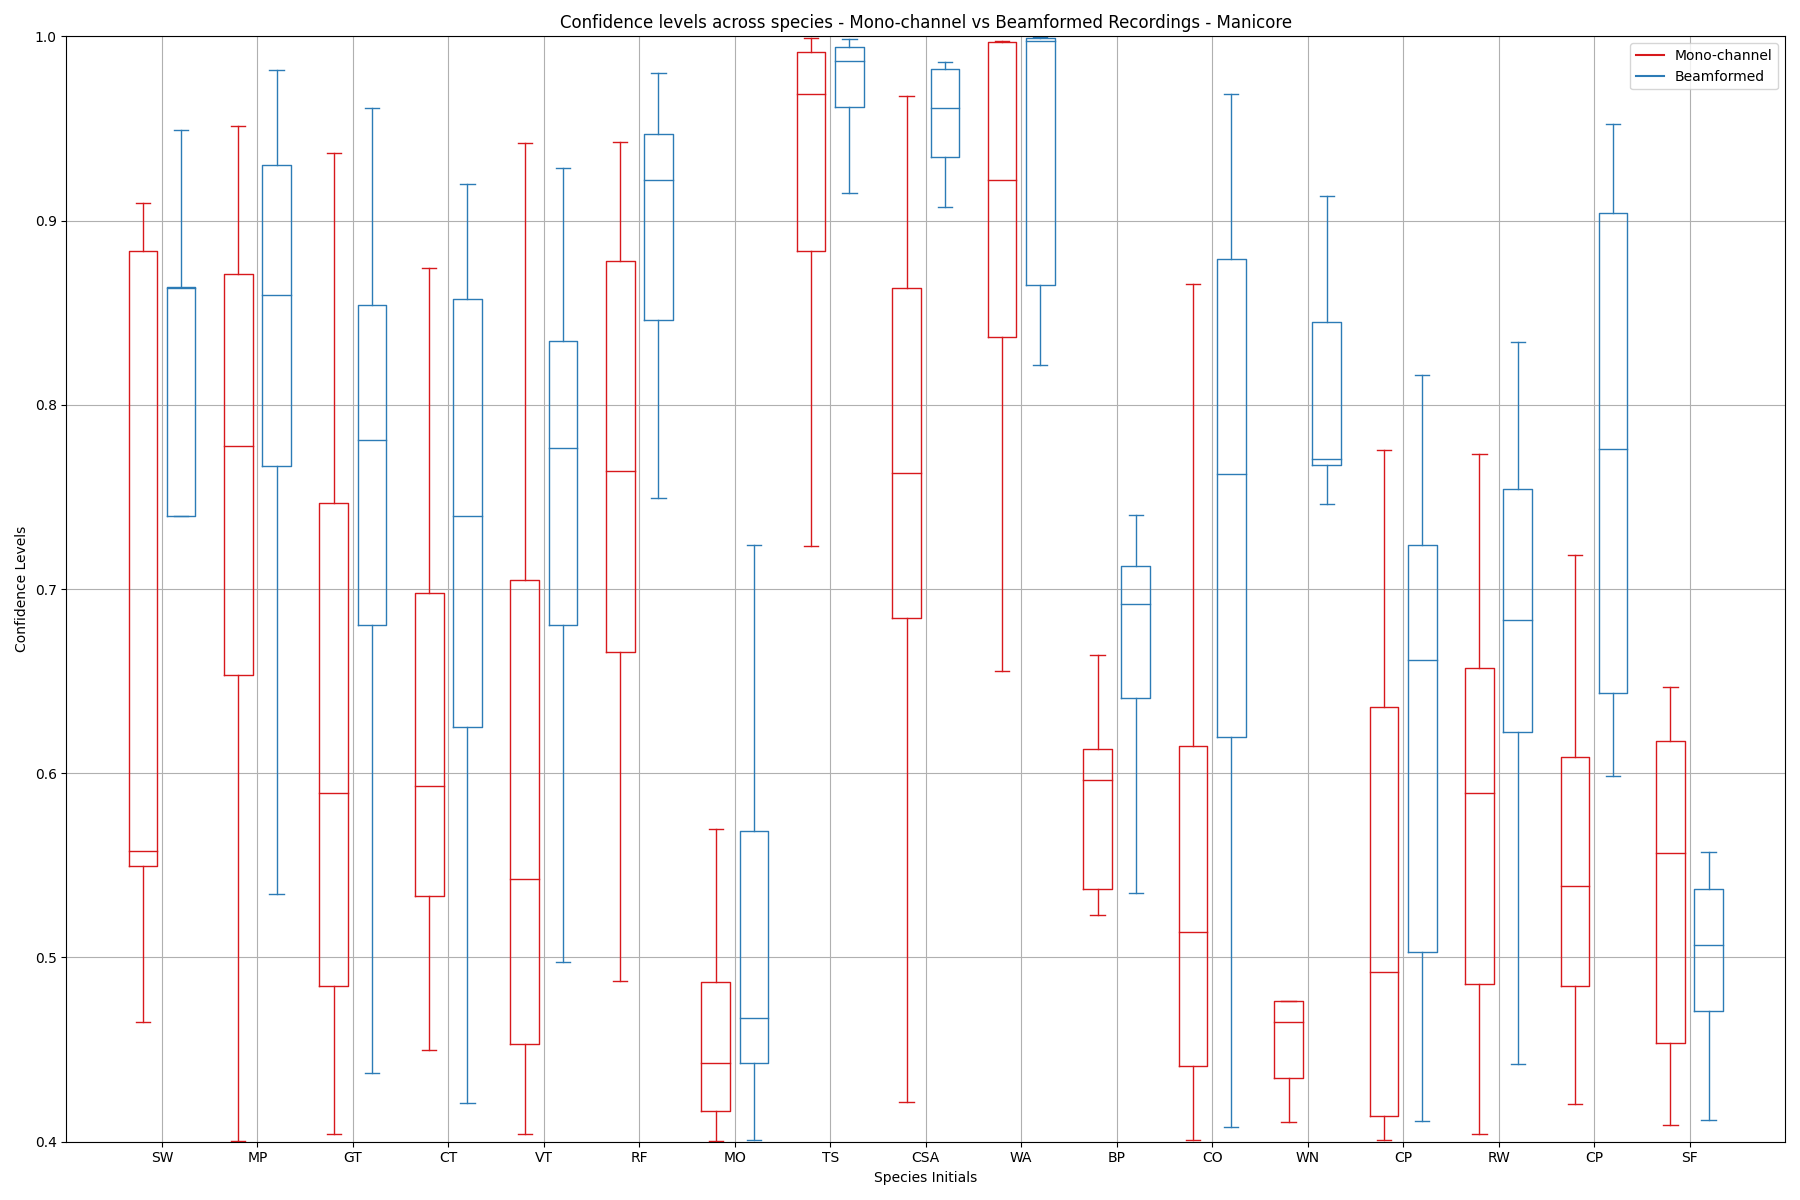

In [66]:
Image('data/processed/manicore/boxcompare.png')

In [65]:
# Slaty-backed Forest-Falcon - see boxplots (above) - beamformed is actually worse

SF_conf_mono = mono_dict["Slaty-backed Forest-Falcon"]["conf_list"]
SF_conf_bf = bf_dict["Slaty-backed Forest-Falcon"]["conf_list"]

statistic, p_value = wilcoxon(SF_conf_mono, SF_conf_bf, alternative="two-sided")

# Print the test statistic and p-value
print("Test Statistic:", statistic)
print("P-value:", p_value)

Test Statistic: 11.0
P-value: 0.3828125


In [90]:
# Mottled Owl - bf median falls within the mono's IQ range

manicore_file_path = "data/processed/manicore/processed.json"
species = "Mottled Owl"

MO_conf_mono = mono_dict[species]["conf_list"]
MO_conf_bf = bf_dict[species]["conf_list"]

statistic, p_value = wilcoxon(MO_conf_mono, MO_conf_bf, alternative="two-sided")

means, medians, devs = get_species_mean_med_dev(manicore_file_path, species)

# Print the test statistic and p-value
print("Two-sided test (is there a signifcant difference)---------------------------")
print("Test Statistic:", statistic)
print("P-value:", p_value)

# Now, repeat with one-sided (to prove conf levels are better after beamforming)
statistic, p_value = wilcoxon(MO_conf_bf, MO_conf_mono, alternative="greater")

# Print the test statistic and p-value
print("Greater test (is the beamformed confidence data signifcantly higher)--------")
print("Test Statistic:", statistic)
print("P-value:", p_value)
print()

report_outcome(means, medians, devs, statistic, p_value)

Two-sided test (is there a signifcant difference)---------------------------
Test Statistic: 116.0
P-value: 0.08148856461048126
Greater test (is the beamformed confidence data signifcantly higher)--------
Test Statistic: 262.0
P-value: 0.04074428230524063

The data is not normally distributed, and descriptive analysis shows 
that the mean confidence level using beamforming (0.51, StDev=0.1) is higher
than the mean confidence level using the mono-channel benchmark recordings 
(0.47, StDev=0.09). It is also noted that the median for beamforming (0.47)
is higher than the median for the mono-channel recordings (0.44).

Non parametric statistics has been used. Wilcoxon signed rank test analysis shows
that this difference is significant (Z=262.0, p=0.041).


Now, let's do it for all species in a processed file...

In [35]:
def wilcoxon_each_species(file_path):
    """Takes a processed.json file/dictionary
    --> For all species, runs a Wilcoxon Signed Rank Test
    --> Reports the number of significant/not-significant tests (and which species)"""
    
    mono_dict = read_results_from_file(file_path)["mono_channel"]
    bf_dict = read_results_from_file(file_path)["beamformed"]

    alternate_count = 0
    total_count = 0
    # signifance_level = 0.05
    signifance_level = 0.05/24      # Bonferroni Correction - 24 species, thus, 24 tests

    significant_species = []
    null_species = []

    sample_threshold = 20           # Minimum num of samples required, for power high enough to show signifance
    # (lower threshold = more tests are not significant)

    # Iterate through all species
    for species in mono_dict.keys():
        if bf_dict[species]["count"] > sample_threshold:
            total_count += 1

            # Extract confidence lists
            conf_bf = bf_dict[species]["conf_list"]
            conf_mono = mono_dict[species]["conf_list"]
            
            # Conduct Wilcoxon signed rank test (one-tail - greater than)
            statistic, p_value = wilcoxon(conf_bf, conf_mono, alternative="greater")

            if p_value < signifance_level:
                alternate_count += 1            # Reject null hypothesis
                significant_species.append(species)
            else:                               # Accept null hypothesis
                null_species.append(species)

    print(f"{str(alternate_count)}/{str(total_count)} tests showed that beamforming led to significantly higher confidence levels.\n"
        +f"Species whose tests showed significance: {significant_species}\n"
        +f"Species whose tests showed no signficance: {null_species}")

In [36]:
manicore_file_path = "data/processed/manicore/processed.json"
silwood_file_path = "data/processed/silwood/A1/processed.json"
lab_file_path = "data/processed/speaker_sphere_lab_tests/processed.json"

print("Manicore - Amazonas, Brazil: ")
wilcoxon_each_species(manicore_file_path)
print()

print("Silwood Park - Reading, UK")
wilcoxon_each_species(silwood_file_path)
print()

# print("Lab Tests - Speaker Sphere")
# wilcoxon_each_species(lab_file_path)
# print()

Manicore - Amazonas, Brazil: 
7/8 tests showed that beamforming led to significantly higher confidence levels.
Species whose tests showed significance: ['Mealy Parrot', 'Green-backed Trogon', 'Variegated Tinamou', 'Rufous-tailed Flatbill', 'Tawny-bellied Screech-Owl', 'Crested Owl', 'Red-necked Woodpecker']
Species whose tests showed no signficance: ['Mottled Owl']

Silwood Park - Reading, UK
14/16 tests showed that beamforming led to significantly higher confidence levels.
Species whose tests showed significance: ['Eurasian Jackdaw', 'Carrion Crow', 'Eurasian Nuthatch', 'Eurasian Green Woodpecker', 'Ring-necked Pheasant', 'Black Redstart', 'Eurasian Blue Tit', 'Common Wood-Pigeon', 'Great Spotted Woodpecker', 'Great Tit', 'Eurasian Jay', 'Stock Dove', 'Coal Tit', 'Common Buzzard']
Species whose tests showed no signficance: ['European Robin', 'Common Kingfisher']



Grace & Lorenzo suggested just running one single Wilcoxon test - combining the confidence readings for all species

Let's do this (for Amazon & Silwood data)...

In [16]:
import matplotlib.pyplot as plt

def set_box_color(bp, color):
    """Sets the colours of a single box, from a matplotlib boxplot"""
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


def get_initials(species_name):
    """Extract the intials from a species' full name"""
    # Split the name into individual words
    words = species_name.split()

    # Extract the first character of each word
    initials = [word[0].upper() for word in words]

    # Return the initials as a string
    return ''.join(initials)


def setup_new_plot(xlabel, ylabel, title):
    """Initialises a new matplotlib plot, with desired parameters"""
    plt.figure(figsize=(18, 12))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

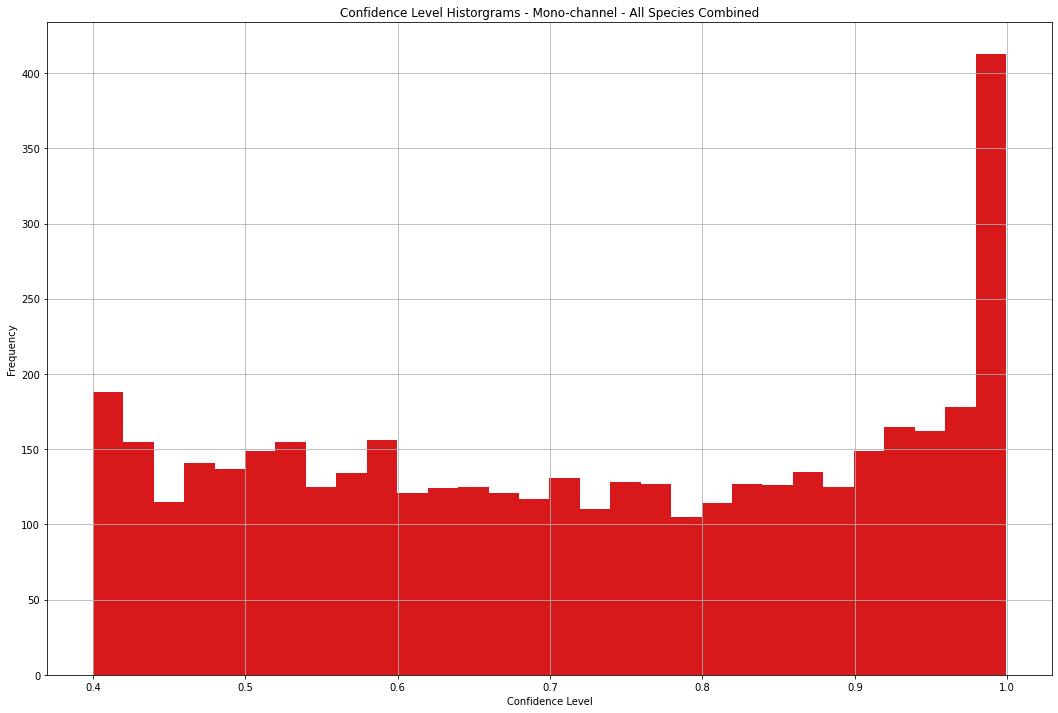

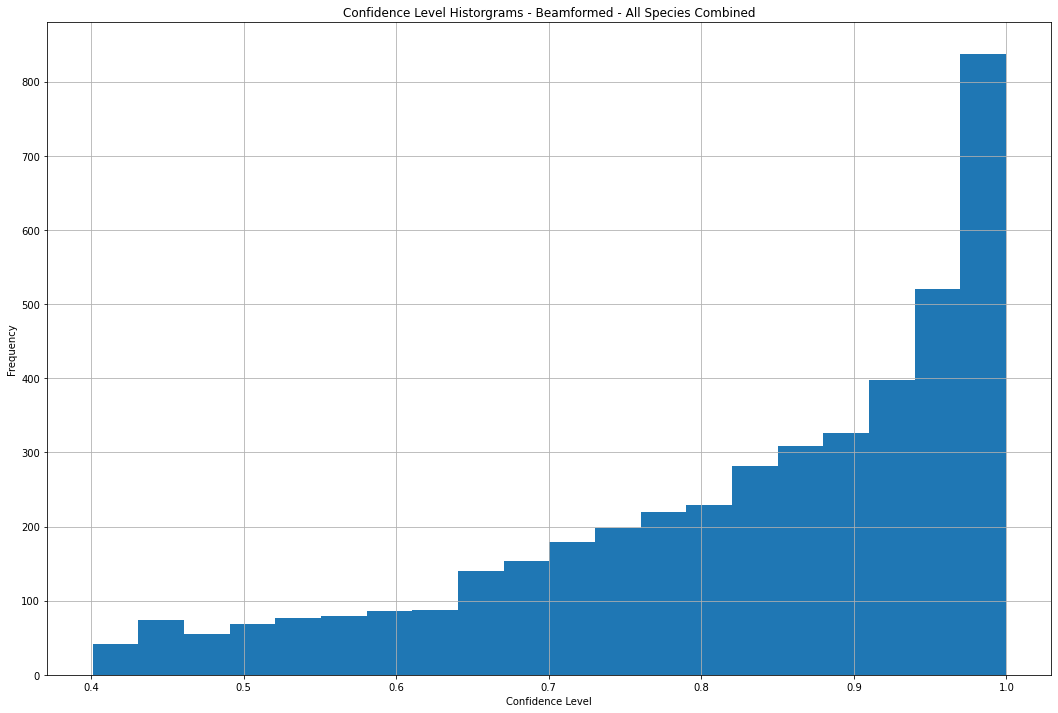

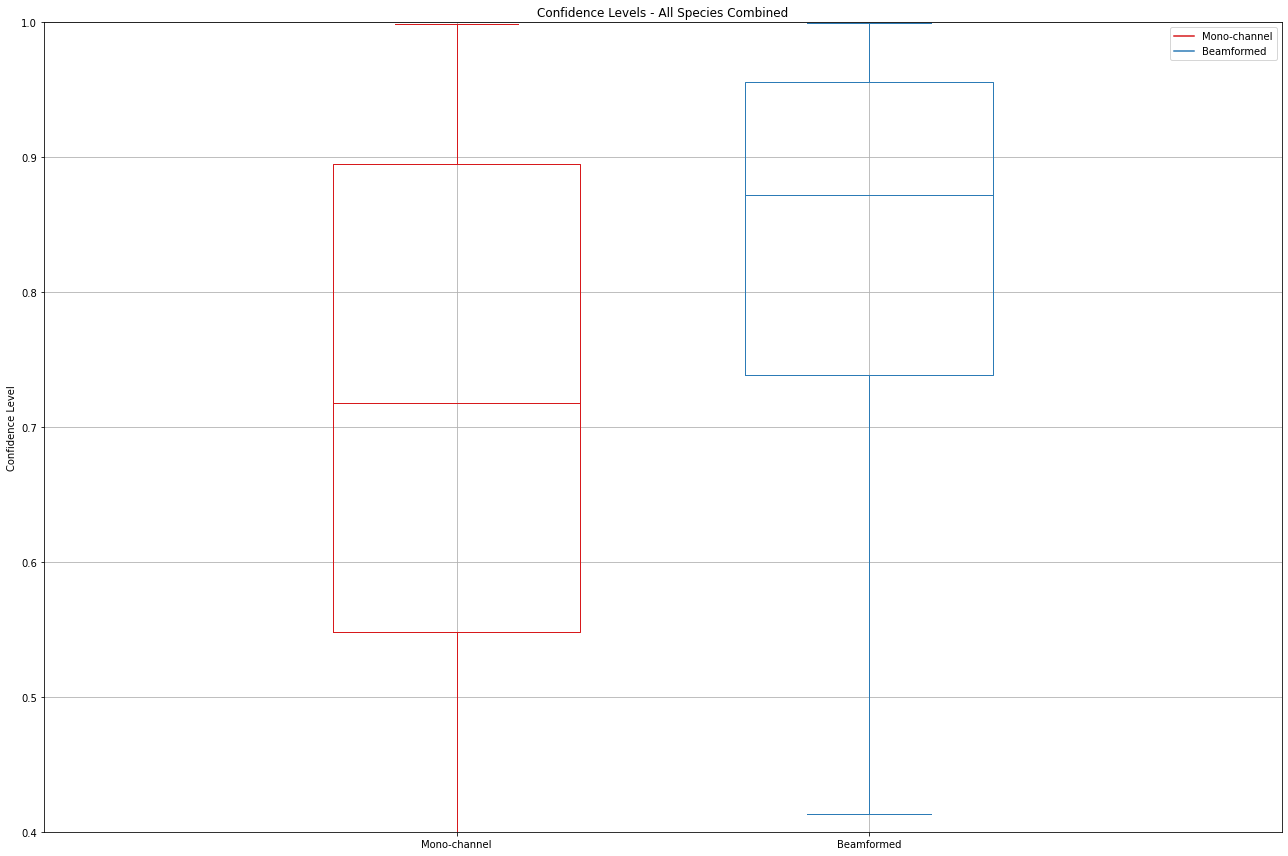

Sample Size: 4358

The data is not normally distributed, and descriptive analysis shows 
that the mean confidence level using beamforming (0.83, StDev=0.151) is higher
than the mean confidence level using the mono-channel benchmark recordings 
(0.717, StDev=0.189). It is also noted that the median for beamforming (0.872)
is higher than the median for the mono-channel recordings (0.718).

Non parametric statistics has been used. Wilcoxon signed rank test analysis shows
that this difference is significant (Z=8457060.0, p<0.001).


In [29]:
import numpy as np

# List for every single detection
conf_bf = []
conf_mono = []

# Add all detections from Manicore-------------------------------------------
manicore_file_path = "data/processed/manicore/processed.json"

mono_dict = read_results_from_file(manicore_file_path)["mono_channel"]
bf_dict = read_results_from_file(manicore_file_path)["beamformed"]

# Iterate through all species
for species in mono_dict.keys():
    # Extract confidence lists
    conf_bf.extend(bf_dict[species]["conf_list"])
    conf_mono.extend(mono_dict[species]["conf_list"])

# Add all detections from Silwood-------------------------------------------
silwood_file_path = "data/processed/silwood/A1/processed.json"

mono_dict = read_results_from_file(silwood_file_path)["mono_channel"]
bf_dict = read_results_from_file(silwood_file_path)["beamformed"]

# Iterate through all species
for species in mono_dict.keys():
    # Extract confidence lists
    conf_bf.extend(bf_dict[species]["conf_list"])
    conf_mono.extend(mono_dict[species]["conf_list"])


# Plot the data (histograms & boxplots)-------------------------------------
# Histograms---
setup_new_plot("Confidence Level", "Frequency", "Confidence Level Historgrams - Mono-channel - All Species Combined")

plt.hist(conf_mono, bins=30, color='#D7191C')
plt.show()

setup_new_plot("Confidence Level", "Frequency", "Confidence Level Historgrams - Beamformed - All Species Combined")

plt.hist(conf_bf, bins=20)
plt.show()

# Boxplots---
setup_new_plot("", "Confidence Level", "Confidence Levels - All Species Combined")

bpl = plt.boxplot(conf_mono, positions=[-1], sym='', widths=0.6)
bpr = plt.boxplot(conf_bf, positions=[0], sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Mono-channel')
plt.plot([], c='#2C7BB6', label='Beamformed')
plt.legend()

boxplot_labels = ["Mono-channel", "Beamformed"]
plt.xticks([-1, 0], boxplot_labels)
plt.xlim(-2, 1)
plt.ylim(0.4, 1)
plt.tight_layout()

plt.show()

# Calculate important metrics-----------------------------------------------
means = [round(np.mean(conf_bf), 3), round(np.mean(conf_mono), 3)]
medians = [round(np.median(conf_bf), 3), round(np.median(conf_mono), 3)]
devs = [round(np.std(conf_bf), 3), round(np.std(conf_mono), 3)]

sample_size = len(conf_bf)
print("Sample Size: " + str(sample_size))
print()

# Conduct the Significance Test---------------------------------------------
statistic, p_value = wilcoxon(conf_bf, conf_mono, alternative="greater")
report_outcome(means, medians, devs, statistic, p_value)

Grace also recommended doing a 'Shapiro Test for Normality' (to prove that the data is non-normal)

1. Michel's lecture notes suggest this is not necessary (unless it's a bit difficult to tell - usually, eyeballing is fine)
2. This paper: "Descriptive Statistics and Normality Tests for Statistical Data"
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/#:~:text=The%20Shapiro–Wilk%20test%20is,taken%20from%20normal%20distributed%20population.
    ...states that "The Shapiro–Wilk test is more appropriate method for small sample sizes (<50 samples) although it can also be handling on larger sample size while Kolmogorov–Smirnov test is used for n ≥50. For both of the above tests, null hypothesis states that data are taken from normal distributed population."
    -> We have so many samples (>4000), thus, we should use the KS test instead

In [37]:
from scipy.stats import kstest
import numpy as np


# For Mono-Channel-------------------------------------------
# Perform Kolmogorov-Smirnov test
statistic, p_value = kstest(conf_mono, 'norm')

# Print the test statistic and p-value
print(f"Kolmogorov-Smirnov test statistic: {statistic}")
print(f"P-value: {p_value}")
print()

# For Beamformed---------------------------------------------
# Perform Kolmogorov-Smirnov test
statistic, p_value = kstest(conf_bf, 'norm')

# Print the test statistic and p-value
print(f"Kolmogorov-Smirnov test statistic: {statistic}")
print(f"P-value: {p_value}")
print()

Kolmogorov-Smirnov test statistic: 0.6554294703879789
P-value: 0.0

Kolmogorov-Smirnov test statistic: 0.6573469057683892
P-value: 0.0

